# Анализ показателей отмененных заказов такси (тестовое задание в Gett)

Идея и данные для мини-проекта взяты с сайта Stratascratch (https://platform.stratascratch.com/data-projects/insights-failed-orders).

Этот проект по обработке данных использовался в качестве тестового задания в процессе набора персонала на должности специалистов по обработке данных в Геттисберге.  

Gett, ранее известная как GetTaxi, представляет собой разработанную в Израиле технологическую платформу, ориентированную исключительно на управление корпоративным наземным транспортом (GTM). У компании есть приложение, в котором клиенты могут заказать такси, а водители могут принимать их поездки (предложения). В тот момент, когда клиент нажимает кнопку заказа в приложении, система подбора ищет наиболее подходящих водителей и предлагает им заказ. В этой задаче необходимо исследовать некоторые показатели заказов, которые не были выполнены успешно, т.е. клиент в конечном итоге не получил автомобиль.

В рамках проекта необходимо выполнить следующие задачи:

1. Проанализировать распределение заказов в соответствии с причинами отказа: отмены до и после назначения водителя, а также причины отклонения заказа. Построить график. Определить, в какой категории больше всего заказов.

2. Построить график распределения невыполненных заказов по часам. Определить, существует ли тенденция к тому, что в определенные часы наблюдается аномально высокая доля той или иной категории? В какие часы происходят самые большие сбои? Как это можно объяснить?

3. Рассчитать среднее время до отмены бронирования с водителем и без него в разбивке по часам. Если в данных есть какие-либо отклонения, было бы лучше их удалить. Можно сделать какие-либо выводы из этого сюжета?

4. Построить график распределения среднего времени до прибытия по часам. Как можно объяснить этот сюжет?

5. Построить почасовую разбивку среднего количества водителей, которым был предложен заказ. Что можно сказать по ней про избыток/нехватку водителей в те или иные часы?

У нас есть два набора данных: ```data_orders``` и ```data_offers```, оба хранятся в формате CSV. 

Набор данных ```data_orders``` содержит следующие столбцы:

* ```order_datetime``` - время отправления заказа

* ```origin_longitude``` - долгота местоположения отправления заказа

* ```origin_latity``` - широта местоположения отправления заказа

* ```m_order_eta``` - время до прибытия водителя 

* ```order_gk``` - номер заказа 

* ```order_status_key``` - статус:
4 - отменено клиентом,
9 - отменено системой, т.е. отклонение

* ```is_driver_assigned_key``` - был ли назначен водитель

* ```cancellation_time_in_seconds``` - сколько секунд прошло до отмены

Набор данных``` data_offers``` представляет собой простую карту с 2 столбцами:

* ```order_gk``` - номер заказа, связанный с тем же столбцом из набора данных заказов

* ```offer_id``` - идентификатор предложения

In [35]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(rc={"figure.figsize":(10, 7)})

In [3]:
data_orders = pd.read_csv("/Users/vladislavoveckin/Desktop/data analysis/Gett_failed_orders/datasets/data_orders.csv")

In [4]:
data_orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [5]:
data_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


In [6]:
data_orders.isna().mean()

order_datetime                   0.000000
origin_longitude                 0.000000
origin_latitude                  0.000000
m_order_eta                      0.737402
order_gk                         0.000000
order_status_key                 0.000000
is_driver_assigned_key           0.000000
cancellations_time_in_seconds    0.318122
dtype: float64

1. Посмотрим, как распределены заказы в соответствии с причинами отказа: отмены до и после назначения водителя, а также причины отклонения заказа.

In [7]:
data_orders.groupby(["is_driver_assigned_key", "order_status_key"])["order_gk"].count().reset_index()

,is_driver_assigned_key,order_status_key,order_gk
0,0,4,4496
1,0,9,3406
2,1,4,2811
3,1,9,3


Чаще всего отмена заказа происходит в случаях, когда водитель не назначен и заказ отменяется клиентом. 
Если водитель назначен, то в основном заказ в таких ситуациях отменяется клиентом.

Построим график распределения заказов в соответствии с причинами отказа.

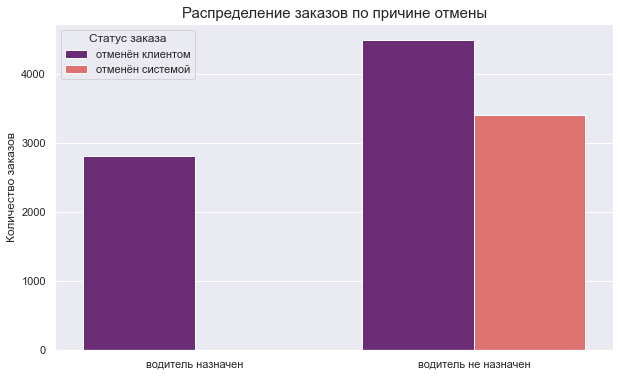

In [36]:
plt.figure(figsize=(10, 6))

sns.countplot(x=data_orders["is_driver_assigned_key"].map({0: "водитель не назначен", 1: "водитель назначен"}), 
              hue=data_orders["order_status_key"].map({4: "отменён клиентом", 9: "отменён системой"}), 
              palette="magma")
plt.title("Распределение заказов по причине отмены", fontsize=15)
plt.xlabel("")
plt.ylabel("Количество заказов")
plt.legend(title = "Статус заказа")
plt.show()

2. Построим графики распределений невыполненных заказов по часам в зависимости от назначения или неназначения водителя и причины отказа. 

In [9]:
data_orders["order_time_hour"] = pd.to_datetime(data_orders.order_datetime).dt.hour

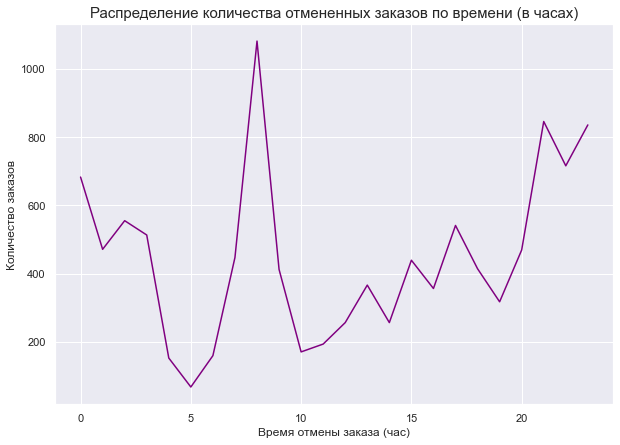

In [37]:
sns.lineplot(x = sorted(data_orders["order_time_hour"].unique()),\
             y = data_orders.groupby("order_time_hour")["order_gk"].count().values, color="purple")
plt.title("Распределение количества отмененных заказов по времени (в часах)", fontsize=15)
plt.xlabel("Время отмены заказа (час)")
plt.ylabel("Количество заказов")
plt.show()

Из графика следует, что пиковые временные промежутки, когда отменяется большое количество заказов, приходятся на 8 часов утра и позднее вечернее время с 21 до 24 часов включительно.

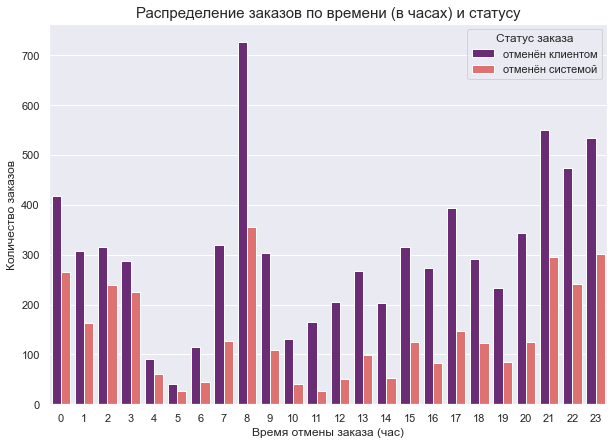

In [38]:
sns.countplot(x=data_orders["order_time_hour"], 
              hue=data_orders["order_status_key"].map({4: "отменён клиентом", 9: "отменён системой"}), 
              palette="magma")
plt.title("Распределение заказов по времени (в часах) и статусу", fontsize=15)
plt.xlabel("Время отмены заказа (час)")
plt.ylabel("Количество заказов")
plt.legend(title = "Статус заказа")
plt.show()

In [12]:
data_orders[data_orders.order_status_key == 4].groupby("order_time_hour")["order_status_key"].mean()

order_time_hour
0     4.0
1     4.0
2     4.0
3     4.0
4     4.0
5     4.0
6     4.0
7     4.0
8     4.0
9     4.0
10    4.0
11    4.0
12    4.0
13    4.0
14    4.0
15    4.0
16    4.0
17    4.0
18    4.0
19    4.0
20    4.0
21    4.0
22    4.0
23    4.0
Name: order_status_key, dtype: float64

Значительная часть невыполненных заказов в 8 часов утра была отменена самими клиентами. Скорее всего, 8 утра является часом пик, когда многие люди добираются на работу и по делам, формируя тем самым высокий спрос на услуги такси, который не получается удовлетворить у компании в виду ограниченного числа автомобилей. По этой причине, время ожидания автомобиля может быть слишком долгим для многих клиентов или же приложение на протяжении длительного времени не может найти подходящий автомобиль, что вынуждает их отказываться от заказов.

В качестве одного из подтверждений данной гипотезы можно рассмотреть среднее время до прибытия водителя (=время ожидания такси) по часам.

In [13]:
data_orders.groupby("order_time_hour")["m_order_eta"].mean()

order_time_hour
0     357.959016
1     324.750000
2     391.012821
3     388.093750
4     299.658537
5     411.120000
6     427.148936
7     583.358974
8     636.910828
9     504.891026
10    355.556962
11    390.954955
12    440.787879
13    428.025000
14    387.835052
15    454.790210
16    440.568182
17    519.742515
18    419.186567
19    369.816667
20    300.096491
21    333.852941
22    372.744966
23    408.429487
Name: m_order_eta, dtype: float64

Действительно, можно обнаружить, что дольше всего по времени клиенты ожидают такси именно в 8 часов утра. 

In [14]:
data_orders.groupby("order_time_hour")["m_order_eta"].mean()[8]/\
data_orders[~(data_orders.order_time_hour == 8)].groupby("order_time_hour")["m_order_eta"].mean().mean()

1.5733995364265414

По сравнению с другими часами в течение дня клиент ожидает такси в среднем на 57 процентов дольше по времени. 

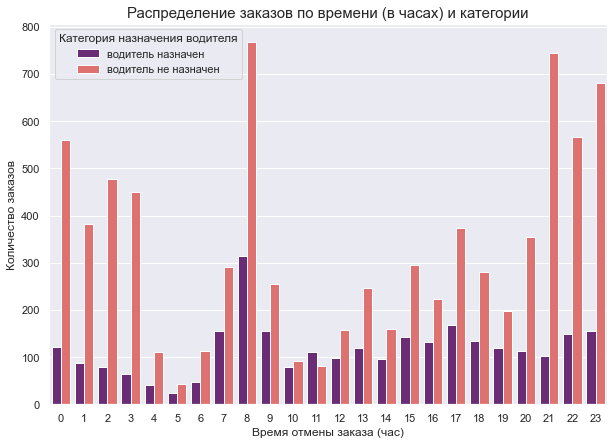

In [39]:
sns.countplot(x=data_orders["order_time_hour"], 
              hue=data_orders["is_driver_assigned_key"].map({0: "водитель не назначен", 1: "водитель назначен"}), 
              palette="magma")
plt.title("Распределение заказов по времени (в часах) и категории", fontsize=15)
plt.xlabel("Время отмены заказа (час)")
plt.ylabel("Количество заказов")
plt.legend(title = "Категория назначения водителя")
plt.show()

На основе графика распределения заказов по категории (назначен водитель или не назначен) можно сделать вывод, что в подавляющем большинстве случаев в 8 часов утра заказ отменяется до назначения водителя, что опять же подтверждает гипотезу о нехватке машин в час пик в условиях очень высокого спроса. Кроме того из графика видно, что в ночные часы в большинстве отмененных заказов водитель так же не был назначен. В данном случае, проблема заключается скорее не в повышенном спросе и невозможности его удовлетворения, а в том, что в ночной период выходят работать гораздо меньше водителей, чем в дневные часы, и система не может найти подходящего для заказа водителя. 

3. Изучим распределение среднего времени до отмены бронирования по часам c назначенным водителем и без него.  

In [16]:
data_orders.groupby("is_driver_assigned_key")["cancellations_time_in_seconds"].agg(["mean", "median"])

,mean,median
is_driver_assigned_key,,
0,110.371441,88.0
1,233.897901,127.0


In [17]:
data_orders[data_orders.is_driver_assigned_key == 0].groupby("order_time_hour")\
                                                ["cancellations_time_in_seconds"].mean()

order_time_hour
0     111.557047
1      98.132420
2     106.438819
3     104.361607
4      90.000000
5     121.800000
6     124.955224
7     112.628049
8     120.702179
9     120.000000
10     74.607843
11     77.945455
12     93.283019
13    103.993243
14     98.415094
15    114.639535
16    129.216783
17    111.533040
18     98.088608
19    112.522124
20    110.086957
21    113.959821
22    104.858896
23    121.756614
Name: cancellations_time_in_seconds, dtype: float64

In [18]:
data_orders[data_orders.is_driver_assigned_key == 1].groupby("order_time_hour")\
                                                ["cancellations_time_in_seconds"].mean()

order_time_hour
0     293.616667
1     247.715909
2     303.307692
3     292.640625
4     243.219512
5     314.400000
6     272.553191
7     188.891026
8     189.025478
9     216.493590
10    197.860759
11    258.423423
12    240.686869
13    248.541667
14    235.618557
15    206.349650
16    220.465649
17    248.125749
18    268.082090
19    198.741667
20    206.692982
21    214.460784
22    232.080537
23    284.557692
Name: cancellations_time_in_seconds, dtype: float64

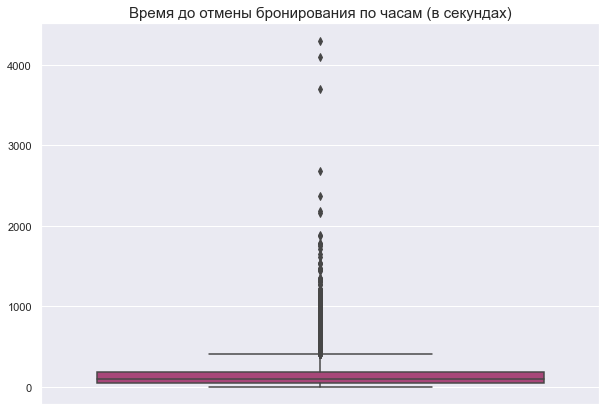

In [40]:
sns.boxplot(y = data_orders["cancellations_time_in_seconds"], palette="magma")
plt.ylabel("")
plt.title("Время до отмены бронирования по часам (в секундах)", fontsize=15)
plt.show()

В данных наблюдаются выбросы. Попробуем удалить часть наблюдений и посмотрим, повлияет ли это существенно на характер распределения времени, прошедшего до отмены бронирования. 

In [20]:
data_orders.cancellations_time_in_seconds.quantile(0.75) + \
1.5*(data_orders.cancellations_time_in_seconds.quantile(0.75) - \
     data_orders.cancellations_time_in_seconds.quantile(0.25))

401.25

In [21]:
data_canc_time = data_orders[~(data_orders.cancellations_time_in_seconds > 400)]

In [22]:
data_canc_time.groupby("is_driver_assigned_key")["cancellations_time_in_seconds"].agg(["mean", "median"])

,mean,median
is_driver_assigned_key,,
0,101.277263,86.0
1,123.796321,91.0


In [23]:
data_canc_time[data_canc_time.is_driver_assigned_key == 0].groupby("order_time_hour")\
                                                ["cancellations_time_in_seconds"].mean()

order_time_hour
0     103.453925
1      98.132420
2     101.205128
3     102.174888
4      90.000000
5     121.800000
6     101.384615
7     108.549383
8     110.412346
9     108.724138
10     66.200000
11     77.945455
12     87.857143
13     98.684932
14     87.596154
15    100.375000
16     97.313869
17     96.804545
18     90.576923
19     95.201835
20    104.174672
21    108.266366
22     99.198142
23    104.839142
Name: cancellations_time_in_seconds, dtype: float64

In [24]:
data_canc_time[data_canc_time.is_driver_assigned_key == 1].groupby("order_time_hour")\
                                                ["cancellations_time_in_seconds"].mean()

order_time_hour
0     146.131868
1     132.985915
2     140.527273
3     115.326087
4     112.096774
5     100.368421
6      89.675676
7     122.962406
8     127.540925
9     127.781955
10    102.184615
11    131.070588
12    102.250000
13    110.270833
14    124.126582
15    121.176471
16    128.223214
17    123.313433
18    124.320755
19    126.784314
20    112.549451
21    125.821429
22    124.983333
23    135.000000
Name: cancellations_time_in_seconds, dtype: float64

В случаях, когда водитель был назначен на выполненение заказа, среднее время до отмены заказа больше по сравнению со случаями, когда водитель назначен не был, независимо от часа поездки. 

4. Построим график распределения среднего времения до прибытия такси по часам. 

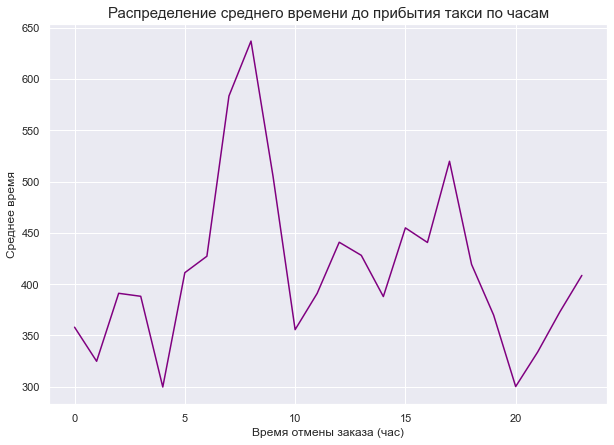

In [41]:
sns.lineplot(x = sorted(data_orders["order_time_hour"].unique()),\
             y = data_orders.groupby("order_time_hour")["m_order_eta"].mean().values, color="purple")
plt.title("Распределение среднего времени до прибытия такси по часам", fontsize=15)
plt.xlabel("Время отмены заказа (час)")
plt.ylabel("Среднее время")
plt.show()

Как видно из графика, дольше всего приезда водителя клиенты ожидают в утренние часы (7-8 часов утра). Как ранее предположили, это связано с высоким спросом на такси в этот промежуток времени, когда люди едут на работу и по делам. В ночные же часы, такси приезжает в среднем быстрее, чем в дневные. 

5. Посмотрим, скольким водителем было предложено взять каждый отдельный заказ.

In [26]:
data_offers = pd.read_csv("/Users/vladislavoveckin/Desktop/data analysis/Gett_failed_orders/datasets/data_offers.csv")

In [27]:
data_offers.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [28]:
offers_by_order = data_offers.groupby("order_gk")["offer_id"].count()

In [29]:
data_orders = data_orders.merge(offers_by_order, how = "left", on = "order_gk")

In [30]:
data_orders["offer_id"]

0        1.0
1        3.0
2        6.0
3        3.0
4        NaN
        ... 
10711    1.0
10712    NaN
10713    1.0
10714    NaN
10715    1.0
Name: offer_id, Length: 10716, dtype: float64

In [31]:
data_orders["offer_id"] = data_orders["offer_id"].fillna(0)

In [32]:
data_orders.groupby("order_time_hour")["offer_id"].mean()

order_time_hour
0     2.918009
1     2.770701
2     2.657658
3     2.764133
4     1.493421
5     1.656716
6     2.465409
7     3.503356
8     3.572089
9     3.053398
10    2.276471
11    2.642487
12    2.722656
13    2.928962
14    2.863281
15    3.289294
16    2.337079
17    2.846580
18    2.743961
19    2.031546
20    2.944563
21    3.288416
22    2.833799
23    2.955742
Name: offer_id, dtype: float64

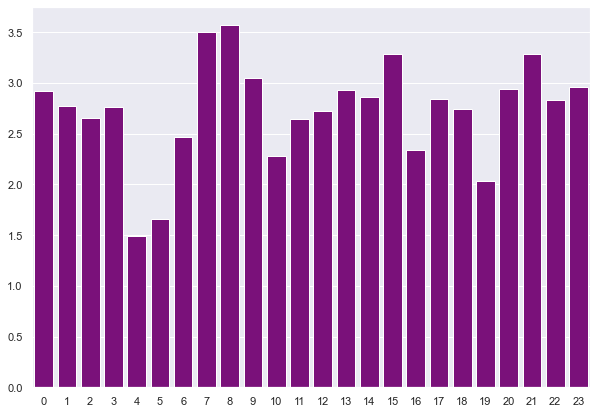

In [42]:
sns.barplot(x=sorted(data_orders["order_time_hour"].unique()), 
            y = data_orders.groupby("order_time_hour")["offer_id"].mean().values,
            color = "darkmagenta")
plt.show()

Основываясь на данном графике, сложно выявить какие-либо существенные различия между средним количествов водителей, которым был предложен заказ, в разные часы и подтвердить вывод про избыток или нехватку водителей в определенное время. Только в 4-5 часов утра среднее количество водителей, которым был предложен заказ, отличается от других часов, но, основываясь на данных, можно заметить, что в это время в целом заказов совершается меньше, чем в остальные часы. 

### Ключевые выводы

1. Большая часть случаев отмены заказов происходит в ситуациях, когда водитель не назначен и заказ отменяется клиентом. Если водитель назначен, заказ в таких случаях чаще отменяется клиентом.

2. Пиковые временные промежутки, когда отменяется большое количество заказов, приходятся на 8 часов утра и позднее вечернее время с 21 до 24 часов включительно.

3. Значительная часть невыполненных заказов в 8 часов утра отменяется самими клиентами. Скорее всего, 8 утра является часом пик, когда многие люди едут на работу и по делам, формируя тем самым высокий спрос на услуги такси, который не получается удовлетворить у компании в виду ограниченного числа автомобилей. По этой причине время ожидания автомобиля может быть слишком долгим для многих клиентов или же приложение на протяжении длительного времени не может найти подходящий автомобиль, что вынуждает клиентов отказываться от заказов.

4. Подтверждением вывода 3 может являться тот факт, что дольше всего приезда водителя клиенты ожидают в утренние часы (7-8 часов утра). В ночные же часы такси приезжает в среднем быстрее, чем в дневные. 

5. Предположение о том, что в ночной период выходят работать гораздо меньше водителей, чем в дневные часы, и поэтому система не может найти подходящего для заказа водителя, не нашло основательного подтверждения. На последнем графике мы видим, что среднее количество водителей, которым был предложен заказ, в ночные часы не отличается от дневного периода, значит достаточное количество водителей работает в это время. При этом по какой-то причине водители не соглашаются на заказы, и системе очень часто приходится их отменять.